In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from  torch.distributions import normal , MultivariateNormal
import GPE_ensemble as GPE

import scipy

dtype = torch.float
device = torch.device("cpu")

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

The code in this notebook gives a simple example of model calibration using the metropolis hastings algorith, the emcee python package and gaussian process emulators

In [2]:
def branin(xx, a=1, b=5.1/(4.0*np.pi**2), c=5.0/np.pi, r=6.0, s=10.0, t=1.0/(8.0*np.pi)): #Branin Function
    x1 = xx[0]
    x2 = xx[1]
    term1 = a * (x2 - b*x1**2 + c*x1 - r)**2
    term2 = s*(1-t)*np.cos(x1)
    y = term1 + term2 + s
    return(y)

In [4]:
rl = [-5,0] #lower observational bound
ru=[10,15] #upper observational bound

tp = 500 # number of test points

#x_test = torch.linspace(ru,rl,tp) #test points over full range


# Using our observational model we want to calibrate to y=3

In [5]:
#Define meshgrid over domain

X=np.linspace(rl[0],ru[0],100) 
Y=np.linspace(rl[1],ru[1],100)
XX,YY=np.meshgrid(X,Y)


In [6]:
Z=branin([XX,YY]) #Evaluate Branin on domain

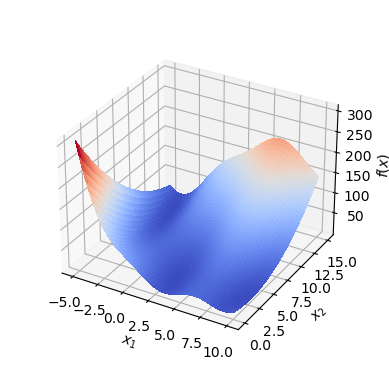

In [7]:
#3D Plot of the Branin function

from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(x)$')
ax.set_box_aspect(None, zoom=0.85)
# Plot the surface.
surf = ax.plot_surface(XX, YY, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.savefig('Branin3D.pdf')  

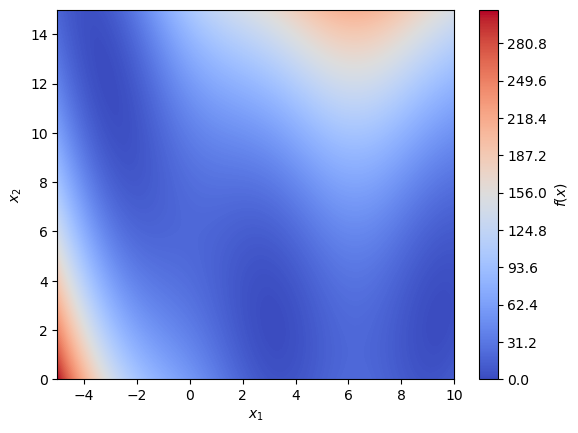

In [8]:
#Contour Plot of the Branin Function

plt.contourf(XX,YY,Z,origin='lower',levels=500,cmap=cm.coolwarm)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(label='$f(x)$')

plt.savefig('Branin2D.pdf')  

In [9]:
# Generates 3 priors and 6 associated posteriors with 2 different observation errors

priors=[]
posterior_e1=[]
posterior_e2=[]
y_cal = 0.397887
prior_means=[[2.5,7.5],[8,2],[4,2]] #3 prior mean locations
prior_sigmas2=[16,9,1] # 3 prior mean variances
e1=1 #Obs error 1
e2=0.1 #Obs error 2
 
for i in range(3):
    priors.append(scipy.stats.multivariate_normal.pdf(np.stack((XX,YY), axis=-1),prior_means[i],prior_sigmas2[i]*np.identity(2)))
    posterior_e1.append(priors[i]*scipy.stats.norm.pdf(Z.reshape(Z.shape[0]*Z.shape[1]),y_cal,e1).reshape(Z.shape[0],Z.shape[1]))
    posterior_e2.append(priors[i]*scipy.stats.norm.pdf(Z.reshape(Z.shape[0]*Z.shape[1]),y_cal,e2).reshape(Z.shape[0],Z.shape[1]))

In [10]:
lev=10 # levels of the contour plot

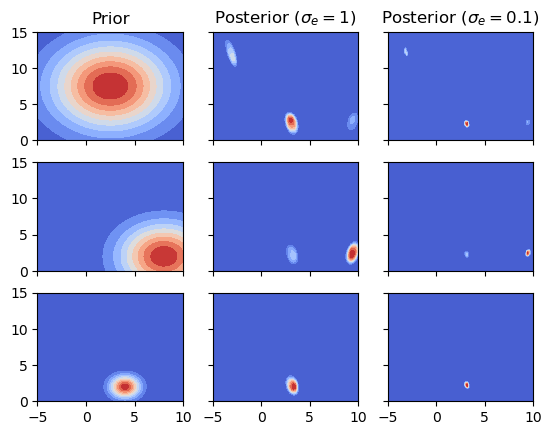

In [11]:
# Plots the three priors and 6 posteriors

fig, ((ax1, ax2,ax3), (ax4, ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3, 3)

ax1.set_title('Prior')
ax2.set_title('Posterior ($\sigma_e=$'+str(e1)+')')
ax3.set_title('Posterior ($\sigma_e=$'+str(e2)+')')

ax1.contourf(XX,YY,priors[0],origin='lower',levels=lev,cmap=cm.coolwarm)
ax2.contourf(XX,YY,posterior_e1[0],origin='lower',levels=lev,cmap=cm.coolwarm)
ax3.contourf(XX,YY,posterior_e2[0],origin='lower',levels=lev,cmap=cm.coolwarm)

ax4.contourf(XX,YY,priors[1],origin='lower',levels=lev,cmap=cm.coolwarm)
ax5.contourf(XX,YY,posterior_e1[1],origin='lower',levels=lev,cmap=cm.coolwarm)
ax6.contourf(XX,YY,posterior_e2[1],origin='lower',levels=lev,cmap=cm.coolwarm)

ax7.contourf(XX,YY,priors[2],origin='lower',levels=lev,cmap=cm.coolwarm)
ax8.contourf(XX,YY,posterior_e1[2],origin='lower',levels=lev,cmap=cm.coolwarm)
ax9.contourf(XX,YY,posterior_e2[2],origin='lower',levels=lev,cmap=cm.coolwarm)

for ax in fig.get_axes():
    ax.label_outer()
    
    

plt.savefig('BraninExactPosterior.pdf')  

In [12]:
# Emulator LL

def log_likelihood_emulator(y,theta,sigma2_e,emulator):
    y=torch.tensor([y])[:,None]
    theta=torch.tensor(theta)
    if theta.dim()==1:
        theta=theta[None]
    sigma2_e=torch.tensor([sigma2_e,sigma2_e])
    ll = emulator.ensemble_log_likelihood_obs_error(theta,y,sigma2_e).detach().numpy()
    return ll

In [17]:
#Trains the two emulators, calculates posteriors, evaluates emulators over domain

np.random.seed(10)

posteriorE_e1=[]
posteriorE_e2=[]

i=0 # Choose which prior from the above 3
p=100 #Number of training points

X=np.random.uniform(rl[0],ru[0],p) #Training point locations
Y=np.random.uniform(rl[1],ru[1],p) #Training point locations

x_train=torch.tensor(np.array([X,Y])) #Training point locations

y_train = branin(x_train) #Observations (function evaluated at training points)

emulator100=GPE.ensemble(x_train.T,y_train[:,None],mean_func='constant') #Train emulator using GPE ensemble

posteriorE_e1.append(priors[i]*np.exp(log_likelihood_emulator(y_cal,np.stack((XX,YY), axis=-1).reshape(10000,2),e1**2,emulator100).reshape(100,100)))

Z100=emulator100.predict(torch.tensor([XX,YY]).T).squeeze().detach().numpy() #Evaulate Emulator
p=10 #Number of training points

X=np.random.uniform(rl[0],ru[0],p)
Y=np.random.uniform(rl[1],ru[1],p) #Training point locations

x_train=torch.tensor(np.array([X,Y]))

y_train = branin(x_train) #Observations (function evaluated at training points)
 

emulator10=GPE.ensemble(x_train.T,y_train[:,None],mean_func='constant') #Train emulator using GPE ensemble

posteriorE_e2.append(priors[i]*np.exp(log_likelihood_emulator(y_cal,np.stack((XX,YY), axis=-1).reshape(10000,2),e1**2,emulator10).reshape(100,100)))

Z10=emulator10.predict(torch.tensor([XX,YY]).T).squeeze().detach().numpy() #Evaulate Emulator

0
Iter 1/1000 - Loss: 1.055
Iter 2/1000 - Loss: 1.016
Iter 3/1000 - Loss: 0.978
Iter 4/1000 - Loss: 0.941
Iter 5/1000 - Loss: 0.904
Iter 6/1000 - Loss: 0.868
Iter 7/1000 - Loss: 0.832
Iter 8/1000 - Loss: 0.797
Iter 9/1000 - Loss: 0.761
Iter 10/1000 - Loss: 0.725
Iter 11/1000 - Loss: 0.689
Iter 12/1000 - Loss: 0.653
Iter 13/1000 - Loss: 0.616
Iter 14/1000 - Loss: 0.579
Iter 15/1000 - Loss: 0.543
Iter 16/1000 - Loss: 0.507
Iter 17/1000 - Loss: 0.470
Iter 18/1000 - Loss: 0.434
Iter 19/1000 - Loss: 0.398
Iter 20/1000 - Loss: 0.360
Iter 21/1000 - Loss: 0.321
Iter 22/1000 - Loss: 0.280
Iter 23/1000 - Loss: 0.237
Iter 24/1000 - Loss: 0.193
Iter 25/1000 - Loss: 0.151
Iter 26/1000 - Loss: 0.113
Iter 27/1000 - Loss: 0.077
Iter 28/1000 - Loss: 0.038
Iter 29/1000 - Loss: -0.003
Iter 30/1000 - Loss: -0.046
Iter 31/1000 - Loss: -0.090
Iter 32/1000 - Loss: -0.132
Iter 33/1000 - Loss: -0.173
Iter 34/1000 - Loss: -0.212
Iter 35/1000 - Loss: -0.252
Iter 36/1000 - Loss: -0.293
Iter 37/1000 - Loss: -0.336

Iter 311/1000 - Loss: -2.324
Iter 312/1000 - Loss: -2.324
Iter 313/1000 - Loss: -2.324
Iter 314/1000 - Loss: -2.325
Iter 315/1000 - Loss: -2.325
Iter 316/1000 - Loss: -2.324
Iter 317/1000 - Loss: -2.325
Iter 318/1000 - Loss: -2.322
Iter 319/1000 - Loss: -2.325
Iter 320/1000 - Loss: -2.325
Iter 321/1000 - Loss: -2.324
Iter 322/1000 - Loss: -2.326
Iter 323/1000 - Loss: -2.325
Iter 324/1000 - Loss: -2.326
Iter 325/1000 - Loss: -2.326
Iter 326/1000 - Loss: -2.327
Iter 327/1000 - Loss: -2.326
Iter 328/1000 - Loss: -2.326
Iter 329/1000 - Loss: -2.324
Iter 330/1000 - Loss: -2.326
Iter 331/1000 - Loss: -2.324
Iter 332/1000 - Loss: -2.327
Iter 333/1000 - Loss: -2.326
Iter 334/1000 - Loss: -2.328
Iter 335/1000 - Loss: -2.328
Iter 336/1000 - Loss: -2.326
Iter 337/1000 - Loss: -2.326
Iter 338/1000 - Loss: -2.329
Iter 339/1000 - Loss: -2.328
Iter 340/1000 - Loss: -2.328
Iter 341/1000 - Loss: -2.329
Iter 342/1000 - Loss: -2.329
Iter 343/1000 - Loss: -2.330
Iter 344/1000 - Loss: -2.328
Iter 345/1000 

Iter 633/1000 - Loss: -2.360
Iter 634/1000 - Loss: -2.360
Iter 635/1000 - Loss: -2.360
Iter 636/1000 - Loss: -2.356
Iter 637/1000 - Loss: -2.356
Iter 638/1000 - Loss: -2.357
Iter 639/1000 - Loss: -2.358
Iter 640/1000 - Loss: -2.358
Iter 641/1000 - Loss: -2.357
Iter 642/1000 - Loss: -2.357
Iter 643/1000 - Loss: -2.365
Iter 644/1000 - Loss: -2.364
Iter 645/1000 - Loss: -2.360
Iter 646/1000 - Loss: -2.367
Iter 647/1000 - Loss: -2.367
Iter 648/1000 - Loss: -2.365
Iter 649/1000 - Loss: -2.366
Iter 650/1000 - Loss: -2.366
Iter 651/1000 - Loss: -2.364
Iter 652/1000 - Loss: -2.368
Iter 653/1000 - Loss: -2.363
Iter 654/1000 - Loss: -2.367
Iter 655/1000 - Loss: -2.367
Iter 656/1000 - Loss: -2.372
Iter 657/1000 - Loss: -2.368
Iter 658/1000 - Loss: -2.366
Iter 659/1000 - Loss: -2.365
Iter 660/1000 - Loss: -2.365
Iter 661/1000 - Loss: -2.365
Iter 662/1000 - Loss: -2.362
Iter 663/1000 - Loss: -2.367
Iter 664/1000 - Loss: -2.366
Iter 665/1000 - Loss: -2.364
Iter 666/1000 - Loss: -2.362
Iter 667/1000 

Iter 950/1000 - Loss: -2.380
Iter 951/1000 - Loss: -2.381
Iter 952/1000 - Loss: -2.381
Iter 953/1000 - Loss: -2.383
Iter 954/1000 - Loss: -2.375
Iter 955/1000 - Loss: -2.379
Iter 956/1000 - Loss: -2.379
Iter 957/1000 - Loss: -2.379
Iter 958/1000 - Loss: -2.377
Iter 959/1000 - Loss: -2.379
Iter 960/1000 - Loss: -2.379
Iter 961/1000 - Loss: -2.378
Iter 962/1000 - Loss: -2.378
Iter 963/1000 - Loss: -2.381
Iter 964/1000 - Loss: -2.382
Iter 965/1000 - Loss: -2.379
Iter 966/1000 - Loss: -2.380
Iter 967/1000 - Loss: -2.382
Iter 968/1000 - Loss: -2.379
Iter 969/1000 - Loss: -2.380
Iter 970/1000 - Loss: -2.378
Iter 971/1000 - Loss: -2.382
Iter 972/1000 - Loss: -2.384
Iter 973/1000 - Loss: -2.380
Iter 974/1000 - Loss: -2.379
Iter 975/1000 - Loss: -2.381
Iter 976/1000 - Loss: -2.380
Iter 977/1000 - Loss: -2.383
Iter 978/1000 - Loss: -2.379
Iter 979/1000 - Loss: -2.378
Iter 980/1000 - Loss: -2.380
Iter 981/1000 - Loss: -2.377
Iter 982/1000 - Loss: -2.380
Iter 983/1000 - Loss: -2.376
Iter 984/1000 

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_69354/759401513.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  Z100=emulator100.predict(torch.tensor([XX,YY]).T).squeeze().detach().numpy() #Evaulate Emulator
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_69354/759401513.py:22: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  Z100=emulator100.predict(torch.tenso

0
Iter 1/1000 - Loss: 1.429
Iter 2/1000 - Loss: 1.399
Iter 3/1000 - Loss: 1.373
Iter 4/1000 - Loss: 1.351
Iter 5/1000 - Loss: 1.329
Iter 6/1000 - Loss: 1.307
Iter 7/1000 - Loss: 1.284
Iter 8/1000 - Loss: 1.258
Iter 9/1000 - Loss: 1.232
Iter 10/1000 - Loss: 1.207
Iter 11/1000 - Loss: 1.182
Iter 12/1000 - Loss: 1.157
Iter 13/1000 - Loss: 1.133
Iter 14/1000 - Loss: 1.109
Iter 15/1000 - Loss: 1.085
Iter 16/1000 - Loss: 1.062
Iter 17/1000 - Loss: 1.040
Iter 18/1000 - Loss: 1.019
Iter 19/1000 - Loss: 1.000
Iter 20/1000 - Loss: 0.981
Iter 21/1000 - Loss: 0.963
Iter 22/1000 - Loss: 0.946
Iter 23/1000 - Loss: 0.931
Iter 24/1000 - Loss: 0.916
Iter 25/1000 - Loss: 0.902
Iter 26/1000 - Loss: 0.889
Iter 27/1000 - Loss: 0.877
Iter 28/1000 - Loss: 0.866
Iter 29/1000 - Loss: 0.855
Iter 30/1000 - Loss: 0.846
Iter 31/1000 - Loss: 0.837
Iter 32/1000 - Loss: 0.829
Iter 33/1000 - Loss: 0.822
Iter 34/1000 - Loss: 0.815
Iter 35/1000 - Loss: 0.810
Iter 36/1000 - Loss: 0.804
Iter 37/1000 - Loss: 0.800
Iter 38/

Iter 404/1000 - Loss: 0.782
Iter 405/1000 - Loss: 0.782
Iter 406/1000 - Loss: 0.782
Iter 407/1000 - Loss: 0.782
Iter 408/1000 - Loss: 0.782
Iter 409/1000 - Loss: 0.782
Iter 410/1000 - Loss: 0.782
Iter 411/1000 - Loss: 0.782
Iter 412/1000 - Loss: 0.782
Iter 413/1000 - Loss: 0.782
Iter 414/1000 - Loss: 0.782
Iter 415/1000 - Loss: 0.782
Iter 416/1000 - Loss: 0.782
Iter 417/1000 - Loss: 0.782
Iter 418/1000 - Loss: 0.782
Iter 419/1000 - Loss: 0.782
Iter 420/1000 - Loss: 0.782
Iter 421/1000 - Loss: 0.782
Iter 422/1000 - Loss: 0.782
Iter 423/1000 - Loss: 0.782
Iter 424/1000 - Loss: 0.782
Iter 425/1000 - Loss: 0.782
Iter 426/1000 - Loss: 0.781
Iter 427/1000 - Loss: 0.782
Iter 428/1000 - Loss: 0.782
Iter 429/1000 - Loss: 0.782
Iter 430/1000 - Loss: 0.782
Iter 431/1000 - Loss: 0.782
Iter 432/1000 - Loss: 0.782
Iter 433/1000 - Loss: 0.782
Iter 434/1000 - Loss: 0.782
Iter 435/1000 - Loss: 0.782
Iter 436/1000 - Loss: 0.782
Iter 437/1000 - Loss: 0.782
Iter 438/1000 - Loss: 0.782
Iter 439/1000 - Loss

Iter 819/1000 - Loss: 0.782
Iter 820/1000 - Loss: 0.782
Iter 821/1000 - Loss: 0.782
Iter 822/1000 - Loss: 0.782
Iter 823/1000 - Loss: 0.782
Iter 824/1000 - Loss: 0.782
Iter 825/1000 - Loss: 0.782
Iter 826/1000 - Loss: 0.781
Iter 827/1000 - Loss: 0.782
Iter 828/1000 - Loss: 0.782
Iter 829/1000 - Loss: 0.782
Iter 830/1000 - Loss: 0.782
Iter 831/1000 - Loss: 0.782
Iter 832/1000 - Loss: 0.782
Iter 833/1000 - Loss: 0.782
Iter 834/1000 - Loss: 0.782
Iter 835/1000 - Loss: 0.782
Iter 836/1000 - Loss: 0.782
Iter 837/1000 - Loss: 0.782
Iter 838/1000 - Loss: 0.782
Iter 839/1000 - Loss: 0.782
Iter 840/1000 - Loss: 0.782
Iter 841/1000 - Loss: 0.782
Iter 842/1000 - Loss: 0.782
Iter 843/1000 - Loss: 0.782
Iter 844/1000 - Loss: 0.782
Iter 845/1000 - Loss: 0.782
Iter 846/1000 - Loss: 0.782
Iter 847/1000 - Loss: 0.781
Iter 848/1000 - Loss: 0.782
Iter 849/1000 - Loss: 0.782
Iter 850/1000 - Loss: 0.782
Iter 851/1000 - Loss: 0.782
Iter 852/1000 - Loss: 0.782
Iter 853/1000 - Loss: 0.781
Iter 854/1000 - Loss

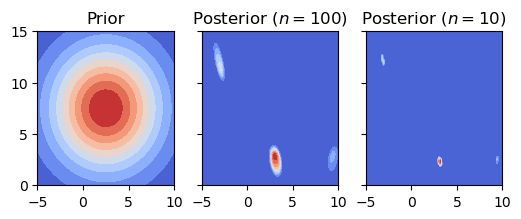

In [18]:
# Plots emulator priors and two posteriors
fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3)

ax1.set_title('Prior')
ax2.set_title('Posterior ($n=100$)')
ax3.set_title('Posterior ($n=10$)')

ax1.contourf(XX,YY,priors[0],origin='lower',levels=lev,cmap=cm.coolwarm)
ax2.contourf(XX,YY,posterior_e1[0],origin='lower',levels=lev,cmap=cm.coolwarm)
ax3.contourf(XX,YY,posterior_e2[0],origin='lower',levels=lev,cmap=cm.coolwarm)




for ax in fig.get_axes():
    ax.label_outer()
    
fig.set_size_inches(6, 2)    

plt.savefig('BraninEmulatorPosterior.pdf')  

In [19]:
levs=np.linspace(-10,350,21) #Set levels for contour plots

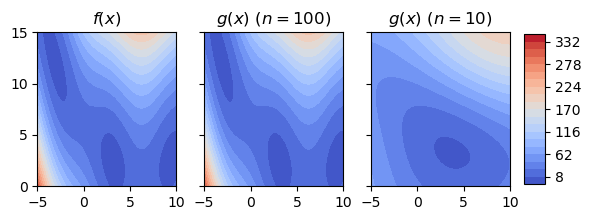

In [20]:
# Contour plots of the emulators
fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3)

ax1.set_title('$f(x)$')
ax2.set_title('$g(x)$ ($n=100$)')
ax3.set_title('$g(x)$ ($n=10$)')

ax1.contourf(XX,YY,Z,origin='lower',levels=levs,cmap=cm.coolwarm)
ax2.contourf(XX,YY,Z100,origin='lower',levels=levs,cmap=cm.coolwarm)
im=ax3.contourf(XX,YY,Z10,origin='lower',levels=levs,cmap=cm.coolwarm)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.03, 0.75])
fig.colorbar(im,cax=cbar_ax, orientation='vertical')


for ax in fig.get_axes():
    ax.label_outer()
    
fig.set_size_inches(7, 2)      

plt.savefig('BraninEmulatorComp.pdf')  

# Calibrating with Metropolis hastings

## The metropolis hastings acceptance probability and algorithm

In [21]:
def acceptance(y,x,x_prime,m1,m2,sigma2,sigmae2): # Log acceptance probabilty (for stability)
    ratio = (-(0.5/sigma2)*((x_prime[0]-m1)**2+(x_prime[1]-m2)**2)-0.5*(1/sigmae2)*(branin(x_prime)-y)**2)-(-(0.5/sigma2)*((x[0]-m1)**2+(x[1]-m2)**2)-0.5*(1/sigmae2)*(branin(x)-y)**2)
    alpha = np.min((0,ratio))
    return alpha

In [22]:
def metrop(y_cal,x0,m1,m2,sigma2_mc,sigma2_prior,sigma2_e,iters):
    chain = np.zeros((iters+1,2)) #Initialise markov chain
    chain[0]=x0 #set x0 as first element
    for i in range(iters):
        x = chain[i] #define x
        x_p = np.random.multivariate_normal(chain[i],sigma2_mc) #select candidate value x'
        alpha = acceptance(y,x,x_p,m1,m2,sigma2_prior,sigma2_e) #calculate alpha
        u=np.random.uniform() #generate random uniform variable
        if np.log(u)<alpha: 
            chain[i+1]=x_p #accept candidate value
        else:
            chain[i+1]=x #reject candidate value
    return chain



In [23]:
y=0.4 # Calibration value for y
sigma2_mc =0.1*np.identity(2) # MCMC proposal variance
sigma2_e=1 # Observation error variance
sigma2_prior=16
iters=10000 # Number of MCMC iterations
m1=2.5
m2=7.5

In [26]:
X=[]
x0=[[11,4],[-1,9],[5,5]]
for i in range(3):
    X.append(metrop(y,x0[i],m1,m2,sigma2_mc,sigma2_prior,sigma2_e,iters))

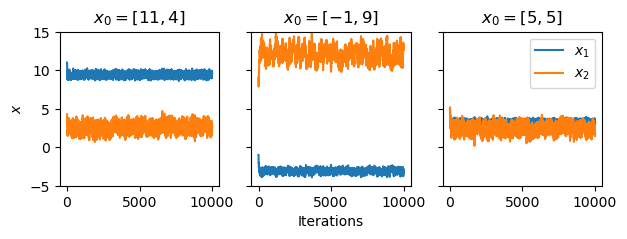

In [27]:
fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3)

ax1.set_title('$x_0=[11,4]$')
ax2.set_title('$x_0=[-1,9]$')
ax3.set_title('$x_0=[5,5]$')

ax1.plot(X[0])
ax1.set_ylim([-5, 15])
ax1.set_ylabel('$x$')
ax2.plot(X[1])
ax2.set_ylim([-5, 15])
ax2.set_xlabel('Iterations')
ax3.plot(X[2])
ax3.set_ylim([-5, 15])
ax3.legend(['$x_1$','$x_2$'])


for ax in fig.get_axes():
    ax.label_outer()
    
fig.set_size_inches(7, 2)      

plt.savefig('BraninMH.pdf')  

# BELOW THIS NOT CURRENTLY USED IN PAPER

But there's more emulator stuff and MCMC using Emcee.

In [ ]:
branin(X.mean(axis=0))

In [ ]:
plt.hist(X[10000::],density=True,bins=50)

In [ ]:
plt.hist(branin(X[10000::].T))

# Calibrating with the emcee package

In [ ]:
import emcee
ndim = 2 #Dimension of x
nwalkers = 20 # Number of emcee walkers (package recommends at least 2 x ndim)
p0 = np.random.multivariate_normal([0,0],50*np.identity(2),nwalkers) #Initial positions for walkers

## Define log-prior, log-likelihood and log-prob for emcee

In [ ]:
def log_prior(theta): #N(0,1) log pdf as the prior
    lp = -(0.5/10)*(theta[0]**2+theta[1]**2)
    return lp

def log_likelihood(y,theta,sigma2_e): #Log likelihood up to proportionality
    ll = -(0.5/(sigma2_e))*(branin(theta)-y)**2
    return ll
    
def log_prob(theta,y,sigma2_e): # Log probability (prior x likelihood)
    
    lp = log_prior(theta)
    ll =log_likelihood( y,theta,sigma2_e)
    return lp + ll

## Set up and run emcee sampler

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[y,sigma2_e]) #Set up an emcee sampler

In [ ]:
sampler.run_mcmc(p0, 10000) # Run sampler

In [ ]:
# Flatten walkers, discard first 2000 points as burn in, thin the samples by 10

flat_samples = sampler.get_chain(discard=2000, thin=10, flat=True) 
print(flat_samples.shape)

## Plot a histogram of the MCMC posterior, the true posterior and the prior

In [ ]:
plt.hist(flat_samples,density=True,bins=100)


## Plot the trace plot

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");


In [ ]:
branin(sampler.get_chain(thin=10,flat=True).mean(axis=0))

In [ ]:
flat_samples

In [ ]:
X[10000::]

In [ ]:
plt.hist(branin(flat_samples.T),density=True)

# MCMC with an emulator in place of $f(x)$

In [ ]:
p=50 #Number of training points

X=np.random.uniform(rl[0],ru[0],p)
Y=np.random.uniform(rl[1],ru[1],p) #Training point locations

x_train=torch.tensor(np.array([X,Y]))

y_train = branin(x_train) #Observations (function evaluated at training points)

In [ ]:
y_train.shape

In [ ]:
emulator=GPE.ensemble(x_train.T,y_train[:,None],mean_func='constant') #Train emulator using GPE ensemble

In [ ]:
Z2=emulator.predict(torch.tensor([XX,YY]).T).squeeze().detach().numpy()

## Plot emulator against true $f(x)$

In [ ]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(XX, YY, Z2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [ ]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(XX, YY, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

## Rewrite log-likelihood and log-prob to account for emulator

In [ ]:
torch.tensor([0,0])[None]

In [ ]:
def log_likelihood_emulator(y,theta,sigma2_e,emulator):
    y=torch.tensor([y])[:,None]
    theta=torch.tensor(theta)
    if theta.dim()==1:
        theta=theta[None]
    sigma2_e=torch.tensor([sigma2_e,sigma2_e])
    ll = emulator.ensemble_log_likelihood_obs_error(theta,y,sigma2_e).detach().numpy()
    return ll
    
def log_prob_emulator(theta,y,sigma2_e,emulator):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll =log_likelihood_emulator(y,theta,sigma2_e,emulator)
    return lp + ll

In [ ]:
log_likelihood_emulator(y,[0,0],sigma2_e,emulator)

## Plot the log-likelihood over the domain

In [ ]:
test=torch.tensor([XX,YY]).T
test.reshape(2500,2).shape

In [ ]:
Z3=log_likelihood_emulator(y,test.reshape(2500,2),sigma2_e,emulator).T

In [ ]:


from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(XX, YY, Z3.reshape((50,50)), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

## Set up and run emcee sampler

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_emulator, args=[y,sigma2_e,emulator])

In [ ]:
p0

In [ ]:
sampler.run_mcmc(p0, 10000)

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

## Plot True posterior against Emulator MCMC, True MCMC and prior

In [ ]:
flat_samples = sampler.get_chain(discard=2000, thin=10, flat=True)
plt.hist(flat_samples,density=True)


In [ ]:
empred=emulator.predict(torch.tensor(flat_samples)).detach().numpy()

In [ ]:
plt.plot(empred)

In [ ]:
plt.hist(empred,density=True)